In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/responsive-ai'

/content/drive/MyDrive/responsive-ai


## Dependencies

In [ ]:
!pip install quantus
!pip install aif360
!pip install captum==0.7.0
!pip install ptflops
!pip install rtdl_revisiting_models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 6.2 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from aif360.sklearn.datasets import fetch_german
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import shap
import quantus
import pickle
from tqdm import tqdm
import time

# Data

## Loading

In [ ]:
# Load and binarize target
X, y = fetch_german()
X.reset_index(drop=True, inplace=True)
y = y.reset_index(drop=True).map({'good':1, 'bad':0}).to_numpy()

# Add your age_group feature, label-encode all categoricals
X['age_group'] = X['age'].apply(lambda x: 'aged' if x>=25 else 'young')

## Preprocessing

In [ ]:

X_enc = X.copy()
cat_cols = X_enc.select_dtypes(['object','category']).columns
cardinalities = []
label_mappings = {}
for col in cat_cols:
    le = LabelEncoder()
    X_enc[col] = le.fit_transform(X_enc[col])
    cardinalities.append(len(le.classes_))
    label_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))

num_cols = [c for c in X_enc.columns if c not in cat_cols]

In [ ]:
for col, mapping in label_mappings.items():
    print(f"\nEncoded mapping for '{col}':")
    for original, encoded in mapping.items():
        print(f"  {original} → {encoded}")


Encoded mapping for 'checking_status':
  0<=X<200 → 0
  <0 → 1
  >=200 → 2
  no checking → 3

Encoded mapping for 'credit_history':
  all paid → 0
  critical/other existing credit → 1
  delayed previously → 2
  existing paid → 3
  no credits/all paid → 4

Encoded mapping for 'purpose':
  business → 0
  domestic appliance → 1
  education → 2
  furniture/equipment → 3
  new car → 4
  other → 5
  radio/tv → 6
  repairs → 7
  retraining → 8
  used car → 9

Encoded mapping for 'savings_status':
  100<=X<500 → 0
  500<=X<1000 → 1
  <100 → 2
  >=1000 → 3
  no known savings → 4

Encoded mapping for 'employment':
  1<=X<4 → 0
  4<=X<7 → 1
  <1 → 2
  >=7 → 3
  unemployed → 4

Encoded mapping for 'other_parties':
  co applicant → 0
  guarantor → 1
  none → 2

Encoded mapping for 'property_magnitude':
  car → 0
  life insurance → 1
  no known property → 2
  real estate → 3

Encoded mapping for 'other_payment_plans':
  bank → 0
  none → 1
  stores → 2

Encoded mapping for 'housing':
  for free → 0

In [ ]:
print(f"\nCardinalities of categorical columns: {cardinalities}")


Cardinalities of categorical columns: [4, 5, 10, 5, 5, 3, 4, 3, 3, 4, 2, 2, 2, 4, 2]


## Splitting and Formatting

In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_enc, y, test_size=0.1, random_state=7
)

# Convert to numpy / tensors
X_train_num = X_train[num_cols].to_numpy(dtype=np.float32)
X_test_num  = X_test[num_cols].to_numpy(dtype=np.float32)
X_train_cat = X_train[cat_cols].to_numpy(dtype=np.int64)
X_test_cat  = X_test[cat_cols].to_numpy(dtype=np.int64)
y_train_np = y_train.astype(np.int64).values if isinstance(y_train, pd.Series) else y_train.astype(np.int64)
y_test_np = y_test.astype(np.int64).values if isinstance(y_test, pd.Series) else y_test.astype(np.int64)

X_train_num_t = torch.from_numpy(X_train_num)
X_train_cat_t = torch.from_numpy(X_train_cat)
X_test_num_t = torch.from_numpy(X_test_num)
X_test_cat_t = torch.from_numpy(X_test_cat)

y_train_t = torch.from_numpy(y_train_np)
y_test_t  = torch.from_numpy(y_test_np)

## Dataloaders

In [ ]:
batch_size = 32
train_ds = TensorDataset(
    torch.from_numpy(X_train_num),
    torch.from_numpy(X_train_cat),
    y_train_t
)
test_ds = TensorDataset(
    torch.from_numpy(X_test_num),
    torch.from_numpy(X_test_cat),
    y_test_t
)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)


# FTTransformer model

In [ ]:
from rtdl_revisiting_models import FTTransformer

# Input dims
d_num = X_train_num.shape[1]
cat_cardinalities = cardinalities
n_cont_features = len(num_cols)
d_out = 2

default_kwargs = FTTransformer.get_default_kwargs()
# default_kwargs['n_blocks'] = 2
default_kwargs['d_block'] = 32
default_kwargs['attention_n_heads'] = 1
# default_kwargs['attention_dropout'] = 0.2   # originally ~0.1
# default_kwargs['ffn_dropout']       = 0.2   # originally ~0.05
# default_kwargs['ffn_residual_dropout']  = 0.05   # originally 0.0
# default_kwargs['residual_dropout']  = 0.05   # originally 0.0 or tiny

model = FTTransformer(
    n_cont_features=n_cont_features,
    cat_cardinalities=cat_cardinalities,
    d_out=d_out,
    **default_kwargs,
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

FTTransformer(
  (cls_embedding): _CLSEmbedding()
  (cont_embeddings): LinearEmbeddings()
  (cat_embeddings): CategoricalEmbeddings(
    (embeddings): ModuleList(
      (0): Embedding(4, 32)
      (1): Embedding(5, 32)
      (2): Embedding(10, 32)
      (3-4): 2 x Embedding(5, 32)
      (5): Embedding(3, 32)
      (6): Embedding(4, 32)
      (7-8): 2 x Embedding(3, 32)
      (9): Embedding(4, 32)
      (10-12): 3 x Embedding(2, 32)
      (13): Embedding(4, 32)
      (14): Embedding(2, 32)
    )
  )
  (backbone): FTTransformerBackbone(
    (blocks): ModuleList(
      (0): ModuleDict(
        (attention): MultiheadAttention(
          (W_q): Linear(in_features=32, out_features=32, bias=True)
          (W_k): Linear(in_features=32, out_features=32, bias=True)
          (W_v): Linear(in_features=32, out_features=32, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
        )
        (attention_residual_dropout): Dropout(p=0.0, inplace=False)
        (ffn_normalization): LayerNo

# Training & Eval

## Training

In [ ]:
X_train_num_t = X_train_num_t.to(device)
X_train_cat_t = X_train_cat_t.to(device)
X_test_num_t = X_test_num_t.to(device)
X_test_cat_t = X_test_cat_t.to(device)

y_train_t = y_train_t.to(device)
y_test_t  = y_test_t .to(device)

num_epochs = 400

start_time = time.time()
for epoch in range(num_epochs):
    # ---- training step ----
    model.train()

    logits = model(X_train_num_t, X_train_cat_t)                    # (batch_size, 2)
    loss = criterion(logits, y_train_t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_train_pred = torch.argmax(logits, dim=1)
    train_accuracy = accuracy_score(y_train_t.cpu().numpy(), y_train_pred.cpu().numpy())

    if ((epoch + 1) % 50) == 0 or (epoch + 1 == 1):
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Training Loss: {loss.item():.4f}   - Training Accuracy: {train_accuracy:.4f}")

# Evaluate on test data
model.eval()
with torch.no_grad():
    logits = model(X_test_num_t, X_test_cat_t)
    probs = torch.softmax(logits, dim=1)
    preds = torch.argmax(probs, dim=1)
    accuracy = (preds == y_test_t).float().mean().item()
    print(f"\nTest Accuracy: {accuracy:.4f}")


end_time = time.time()
elapsed_time = end_time - start_time


Epoch [1/400]
Training Loss: 0.6778   - Training Accuracy: 0.6033
Epoch [50/400]
Training Loss: 0.5177   - Training Accuracy: 0.7467
Epoch [100/400]
Training Loss: 0.4590   - Training Accuracy: 0.7844
Epoch [150/400]
Training Loss: 0.4145   - Training Accuracy: 0.8156
Epoch [200/400]
Training Loss: 0.3608   - Training Accuracy: 0.8422
Epoch [250/400]
Training Loss: 0.3187   - Training Accuracy: 0.8500
Epoch [300/400]
Training Loss: 0.2686   - Training Accuracy: 0.8933
Epoch [350/400]
Training Loss: 0.2385   - Training Accuracy: 0.8956
Epoch [400/400]
Training Loss: 0.1852   - Training Accuracy: 0.9167

Test Accuracy: 0.8000


In [ ]:
print("\nTotal training time: ", elapsed_time)


Total training time:  5.392465114593506


In [ ]:
# Saving the model
torch.save(model.state_dict(), "saved_model/fttransformer_german.pth")

## Eval

In [ ]:
# Loading the model
model.load_state_dict(torch.load("saved_model/fttransformer_german.pth"))

<All keys matched successfully>

In [ ]:
X_test_num_t = X_test_num_t.to(device)
X_test_cat_t = X_test_cat_t.to(device)
y_test_t  = y_test_t .to(device)
model.eval()
with torch.no_grad():
    logits = model(X_test_num_t, X_test_cat_t)
    probs = torch.softmax(logits, dim=1)
    preds = torch.argmax(probs, dim=1)
    accuracy = (preds == y_test_t).float().mean().item()
    print(f"\nTest Accuracy: {accuracy:.4f}")


Test Accuracy: 0.8000


## Training with bs

In [ ]:
num_epochs = 100
start_time = time.time()
for epoch in range(1, num_epochs+1):
    model.train()
    total_loss = 0
    all_preds, all_targets = [], []

    for Xn, Xc, yb in tqdm(train_loader, desc=f"Epoch {epoch:02d}", leave=False):
        Xn, Xc, yb = Xn.to(device), Xc.to(device), yb.to(device)
        logits = model(Xn, Xc)                    # (batch_size, 2)
        loss = criterion(logits, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * Xn.size(0)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(yb.cpu().numpy())

    # Epoch metrics
    train_loss = total_loss / len(train_loader.dataset)
    train_acc  = accuracy_score(
        np.concatenate(all_targets), np.concatenate(all_preds)
    )

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d}  Loss: {train_loss:.4f}  Acc: {train_acc:.4f}")

end_time = time.time()
elapsed_time = end_time - start_time

Epoch 01  Loss: 0.4685  Acc: 0.7711


Epoch 10  Loss: 0.4715  Acc: 0.7600


Epoch 20  Loss: 0.4665  Acc: 0.7800


Epoch 30  Loss: 0.4573  Acc: 0.7733


Epoch 40  Loss: 0.4598  Acc: 0.7733


Epoch 50  Loss: 0.4446  Acc: 0.7878


Epoch 60  Loss: 0.4441  Acc: 0.7856


Epoch 70  Loss: 0.4295  Acc: 0.7944


Epoch 80  Loss: 0.4344  Acc: 0.7800


Epoch 90  Loss: 0.4229  Acc: 0.7956


Epoch 100  Loss: 0.4466  Acc: 0.7944


## Eval with bs

In [ ]:
# Loading the model
model.load_state_dict(torch.load("saved_model/fttransformer_german.pth"))

C:\Users\hungd\AppData\Local\Temp\ipykernel_19568\2454809802.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("saved_model/fttransformer_

<All keys matched successfully>

In [ ]:
# 6. Evaluation on Test Set
model.eval()
test_preds, test_targets = [], []
with torch.no_grad():
    for Xn, Xc, yb in tqdm(test_loader, desc="Testing", leave=False):
        Xn, Xc = Xn.to(device), Xc.to(device)
        logits = model(Xn, Xc)
        test_preds.append(logits.argmax(dim=1).cpu().numpy())
        test_targets.append(yb.numpy())

test_acc = accuracy_score(
    np.concatenate(test_targets),
    np.concatenate(test_preds)
)
print(f"FT-Transformer Test Accuracy: {test_acc:.4f}")


FT-Transformer Test Accuracy: 0.7700


In [ ]:
# Saving the model
torch.save(model.state_dict(), "saved_model/fttransformer_german.pth")

# Sustainability

## Param Count

In [ ]:
# Parameter Count (Pure PyTorch)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Usage
total_params = count_parameters(model)
print(f"Trainable parameters: {total_params:,}")

Trainable parameters: 25,214


## FLOPs

In [ ]:
# Calculate FLOPS
from torch.utils.flop_counter import FlopCounterMode

X_test_num_torch = torch.from_numpy(X_test_num).to(device)    # float32 tensor, shape (n_test, n_cont)
X_test_cat_torch = torch.from_numpy(X_test_cat).to(device)

sample_num    = X_test_num_torch[0:1]  # shape (1, n_cont)
sample_cat    = X_test_cat_torch[0:1]  # shape (1, n_cat)

model.eval()
with FlopCounterMode() as flop_counter:
    _ = model(sample_num, sample_cat)

flops_per_sample = flop_counter.get_total_flops()
print(f"FLOPs per sample: {flops_per_sample/1e3:.2f} K")
print(f"FLOPs: {flops_per_sample*X_test_num_torch.shape[0]/1e6:.2f}M")

Module                        FLOP    % Total
-----------------------  ---------  ---------
FTTransformer            1073.792K    100.00%
 - aten.addmm             935.424K     87.11%
 - aten.bmm               138.368K     12.89%
 FTTransformer.backbone  1073.792K    100.00%
  - aten.addmm            935.424K     87.11%
  - aten.bmm              138.368K     12.89%
FLOPs per sample: 1073.79 K
FLOPs: 107.38M


## MACs

In [ ]:
n_cont = X_test_num.shape[1]
n_cat  = X_test_cat.shape[1]
cat_cardinalities = cardinalities  # list of ints, one per categorical column

class FTTransformerSingleInput(nn.Module):
    def __init__(self, ft_model, n_cont, n_cat, cat_cardinalities):
        super().__init__()
        self.ft = ft_model
        self.n_cont = n_cont
        self.n_cat = n_cat
        self.cat_cardinalities = cat_cardinalities

    def forward(self, x_combined):
        x_num = x_combined[:, : self.n_cont].float()
        x_cat = x_combined[:, self.n_cont : self.n_cont + self.n_cat].long()
        # Clip to valid category range:
        for i, card in enumerate(self.cat_cardinalities):
            x_cat[:, i] = torch.clamp(x_cat[:, i], 0, card - 1)
        return self.ft(x_num, x_cat)

wrapped = FTTransformerSingleInput(model, n_cont, n_cat, cat_cardinalities)
wrapped.to(device)
wrapped.eval()

FTTransformerSingleInput(
  (ft): FTTransformer(
    (cls_embedding): _CLSEmbedding()
    (cont_embeddings): LinearEmbeddings()
    (cat_embeddings): CategoricalEmbeddings(
      (embeddings): ModuleList(
        (0): Embedding(4, 32)
        (1): Embedding(5, 32)
        (2): Embedding(10, 32)
        (3-4): 2 x Embedding(5, 32)
        (5): Embedding(3, 32)
        (6): Embedding(4, 32)
        (7-8): 2 x Embedding(3, 32)
        (9): Embedding(4, 32)
        (10-12): 3 x Embedding(2, 32)
        (13): Embedding(4, 32)
        (14): Embedding(2, 32)
      )
    )
    (backbone): FTTransformerBackbone(
      (blocks): ModuleList(
        (0): ModuleDict(
          (attention): MultiheadAttention(
            (W_q): Linear(in_features=32, out_features=32, bias=True)
            (W_k): Linear(in_features=32, out_features=32, bias=True)
            (W_v): Linear(in_features=32, out_features=32, bias=True)
            (dropout): Dropout(p=0.2, inplace=False)
          )
          (attenti

In [ ]:
from ptflops import get_model_complexity_info

input_shape = (n_cont + n_cat,)
with torch.cuda.device(0):
    macs_str, params_str = get_model_complexity_info(
        wrapped,
        input_shape,
        as_strings=True,
        print_per_layer_stat=True,
        verbose=True,
    )

print(f"MACs per sample (string): {macs_str}")
print(f"Params (string)      : {params_str}")

# Parse the MACs string into a float (number of multiply-adds per sample)
def parse_macs_str(s):
    if s.endswith(" GMac"):
        return float(s.replace(" GMac", "")) * 1e9
    if s.endswith(" MMac"):
        return float(s.replace(" MMac", "")) * 1e6
    if s.endswith(" KMac"):
        return float(s.replace(" KMac", "")) * 1e3
    if s.endswith(" Mac"):
        return float(s.replace(" Mac", ""))
    raise ValueError(f"Unrecognized MACs format: {s}")

macs_per_sample = parse_macs_str(macs_str)
print(f"MACs per sample: {macs_per_sample/1e3:.2f} K")
total_macs = macs_per_sample * X_test_num.shape[0]
print(f"MACs: {total_macs/1e6:.2f} M")

FTTransformerSingleInput(
  22.4 k, 88.832% Params, 485.38 KMac, 99.180% MACs, 
  (ft): FTTransformer(
    22.4 k, 88.832% Params, 485.38 KMac, 99.180% MACs, 
    (cls_embedding): _CLSEmbedding(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
    (cont_embeddings): LinearEmbeddings(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
    (cat_embeddings): CategoricalEmbeddings(
      0, 0.000% Params, 0.0 Mac, 0.000% MACs, 
      (embeddings): ModuleList(
        (0): Embedding(0, 0.000% Params, 0.0 Mac, 0.000% MACs, 4, 32)
        (1): Embedding(0, 0.000% Params, 0.0 Mac, 0.000% MACs, 5, 32)
        (2): Embedding(0, 0.000% Params, 0.0 Mac, 0.000% MACs, 10, 32)
        (3-4): 2 x Embedding(0, 0.000% Params, 0.0 Mac, 0.000% MACs, 5, 32)
        (5): Embedding(0, 0.000% Params, 0.0 Mac, 0.000% MACs, 3, 32)
        (6): Embedding(0, 0.000% Params, 0.0 Mac, 0.000% MACs, 4, 32)
        (7-8): 2 x Embedding(0, 0.000% Params, 0.0 Mac, 0.000% MACs, 3, 32)
        (9): Embedding(0, 0.000% Params, 0.0 Mac, 0.000

## kgCO2e

In [ ]:
def compute_kgco2e(pc, pg, time):
    """
    Compute kgCO2 emission, and normalized emission per capita.
    Args:
        pc: average CPU power in watts
        pg: average GPU power in watts
        time: training + eval time

    Returns:
        tuple: CO2e (kg), normalized CO2e
    """
    pt = (pc + pg) * time / 1000  # power in kWh
    co2e = 0.498 * pt  # Germany's emission rate
    normalized = co2e / 26  # per-capita daily emission baseline

    return co2e, normalized

In [ ]:
"""
Intel(R) Xeon(R) CPU @ 2.20GHz
Model: 79 (
-> Intel Xeon E5-2673 v4 from the Broadwell-EP family - specifications:
    Cores: 10
    Threads: 20
    Base Frequency: 2.3 GHz
    Maximum Turbo Speed: 3.5 GHz
    Cache: 50 MB
    TDP: 135W

Colab uses 2 vCPUs (each 1 core -> total 2 cores out of 20)
-> only use 10% of the actuall TDP -> 13.5 W
"""
pc = 13.5
pg = 70

In [ ]:
kgco2e, kgco2e_normalized = compute_kgco2e(pc, pg, elapsed_time)

print(f"kgCO2 emission: {kgco2e:.4f} kg")
print(f"Normalized kgCO2 emission: {kgco2e_normalized:.4f}")

kgCO2 emission: 0.2242 kg
Normalized kgCO2 emission: 0.0086


# Explainability

## SHAP

In [ ]:
X_test_combined = np.hstack([X_test_num, X_test_cat])  # shape (n_test, n_cont + n_cat)
y_test_int = y_test_np.astype(np.int64)

In [ ]:
n_cont = X_test_num.shape[1]
n_cat  = X_test_cat.shape[1]
background = X_test_combined[:100]


def f_shap(combined_X: np.ndarray) -> np.ndarray:
    """
    combined_X has shape (batch_size, n_cont + n_cat).
    We split it into numeric vs. categorical, convert to torch, pass through FTTransformer,
    and return P(class=1) as a 1D numpy array of length batch_size.
    """
    model.eval()
    # split
    X_num_np = combined_X[:, :n_cont].astype(np.float32)
    X_cat_np = combined_X[:, n_cont:].astype(np.int64)

    with torch.no_grad():
        Xn = torch.from_numpy(X_num_np).to(device)
        Xc = torch.from_numpy(X_cat_np).to(device)
        logits = model(Xn, Xc)                  # shape (batch_size, 2)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
    return probs[:, 1]  # P(class=1)

In [ ]:
explainer = shap.KernelExplainer(f_shap, background)

In [ ]:
# with open('saved_shap/fttransformer_shap_values_german.pkl', 'rb') as f:
#     shap_values = pickle.load(f)

In [ ]:
shap_values = explainer.shap_values(X_test_combined, nsamples=100)

100%|██████████| 100/100 [06:07<00:00,  3.68s/it]


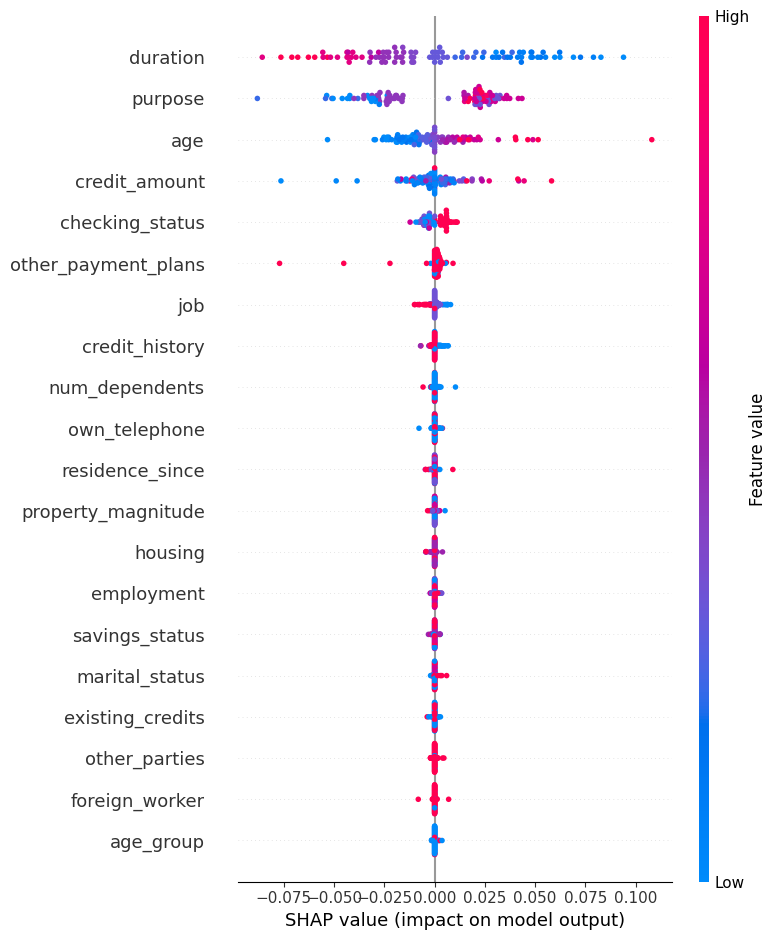

In [ ]:
feature_names = list(num_cols) + list(cat_cols)
shap.summary_plot(shap_values, X_test_combined, feature_names=feature_names)

In [ ]:
with open('saved_shap/fttransformer_shap_values_german.pkl', 'wb') as f:
    pickle.dump(shap_values, f)


## Quantus

### Wrapped Model

In [ ]:
class FTModelWrapper(nn.Module):
    """
    Wraps an FTTransformer so that Quantus can call `.forward(x)` and `.predict(x)`,
    where x is a 2D numpy array of shape (batch_size, n_cont + n_cat). Internally,
    we split into numeric vs. categorical tensors and forward them to the FTTransformer.
    """
    def __init__(self, ft_model: nn.Module, cat_cardinalities: list):
        super(FTModelWrapper, self).__init__()
        self.model = ft_model
        self.model.eval()
        self.cat_cardinalities = cat_cardinalities  # Store cardinalities for clipping

    def _clip_categorical_indices(self, x_cat: torch.Tensor) -> torch.Tensor:
        """
        Clip categorical indices to valid ranges based on cardinalities.
        """
        x_cat_clipped = x_cat.clone()
        for i, cardinality in enumerate(self.cat_cardinalities):
            # Clip to valid range [0, cardinality-1]
            x_cat_clipped[:, i] = torch.clamp(x_cat_clipped[:, i], 0, cardinality - 1)
        return x_cat_clipped

    def forward(self, combined_x: torch.Tensor) -> torch.Tensor:
        """
        combined_x: torch.Tensor of shape (batch_size, n_cont + n_cat), dtype float or long.
        We'll split it into (X_num, X_cat).
        """
        # split along last dim
        Xn = combined_x[:, :n_cont].float().to(device)
        Xc = combined_x[:, n_cont:].long().to(device)

        # Clip categorical indices to valid ranges
        Xc = self._clip_categorical_indices(Xc)

        logits = self.model(Xn, Xc)  # shape (batch_size, 2)
        return logits

    def predict(self, combined_X: np.ndarray) -> np.ndarray:
        """
        combined_X: numpy array of shape (batch_size, n_cont + n_cat).
        Returns: probabilities (batch_size, 2).
        """
        self.model.eval()
        with torch.no_grad():
            # convert to torch
            t = torch.from_numpy(combined_X).float().to(device)
            logits = self.forward(t)  # shape (batch_size, 2)
            probs = torch.softmax(logits, dim=1).cpu().numpy()
        return probs

    def shape_input(self, x: np.ndarray, shape, channel_first: bool) -> np.ndarray:
        """For Quantus: ensure x is at least 2D."""
        return np.atleast_2d(x)

# Update the instantiation to include cardinalities:
wrapped_model = FTModelWrapper(model, cat_cardinalities=cardinalities)
wrapped_model.eval()  # set to eval mode

FTModelWrapper(
  (model): FTTransformer(
    (cls_embedding): _CLSEmbedding()
    (cont_embeddings): LinearEmbeddings()
    (cat_embeddings): CategoricalEmbeddings(
      (embeddings): ModuleList(
        (0): Embedding(4, 192)
        (1): Embedding(5, 192)
        (2): Embedding(10, 192)
        (3-4): 2 x Embedding(5, 192)
        (5): Embedding(3, 192)
        (6): Embedding(4, 192)
        (7-8): 2 x Embedding(3, 192)
        (9): Embedding(4, 192)
        (10-12): 3 x Embedding(2, 192)
        (13): Embedding(4, 192)
        (14): Embedding(2, 192)
      )
    )
    (backbone): FTTransformerBackbone(
      (blocks): ModuleList(
        (0): ModuleDict(
          (attention): MultiheadAttention(
            (W_q): Linear(in_features=192, out_features=192, bias=True)
            (W_k): Linear(in_features=192, out_features=192, bias=True)
            (W_v): Linear(in_features=192, out_features=192, bias=True)
            (W_out): Linear(in_features=192, out_features=192, bias=True)

### Complexity

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 3.1. Complexity (Bhatt et al., 2020) from SHAP attributions
# ──────────────────────────────────────────────────────────────────────────────
Complexity_shap = quantus.Complexity(
    normalise=False,
    abs=True,                 # take absolute values of attributions
    disable_warnings=True,
    display_progressbar=True,
    aggregate_func=np.mean   # mean over all samples
)(
    model=wrapped_model,
    x_batch=X_test_combined,
    y_batch=y_test_int,
    a_batch=shap_values,     # precomputed SHAP values (shape: n_test × (n_cont + n_cat))
    explain_func=None
)

# Scale to [0,1]
Complexity_shap = np.array(Complexity_shap)
Complexity_shap = (Complexity_shap - Complexity_shap.min()) / (Complexity_shap.max() - Complexity_shap.min())
Complexity_shap = float(np.mean(Complexity_shap))

print("Complexity (Bhatt et al., 2020) [SHAP]:", round(Complexity_shap, 4))

  0%|          | 0/2.0 [00:00<?, ?it/s]

Complexity (Bhatt et al., 2020) [SHAP]: 0.6635


In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 3.2. Sparseness (Chalasani et al., 2020)
# ──────────────────────────────────────────────────────────────────────────────
Sparseness_shap = quantus.Sparseness(
    normalise=False,
    abs=True,
    disable_warnings=True,
    display_progressbar=True,
    return_aggregate=True,    # return a single mean value
    aggregate_func=np.mean
)(
    model=wrapped_model,
    x_batch=X_test_combined,
    y_batch=y_test_int,
    a_batch=shap_values,
    explain_func=None
)

Sparseness_shap = np.array(Sparseness_shap)  # ensure it's a numpy array
Sparseness_shap = float(Sparseness_shap)
print("Sparseness (Chalasani et al., 2020) [SHAP]:", round(Sparseness_shap, 4))

  0%|          | 0/2.0 [00:00<?, ?it/s]

Sparseness (Chalasani et al., 2020) [SHAP]: 0.8317


C:\Users\hungd\AppData\Local\Temp\ipykernel_19568\3405702079.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Sparseness_shap = float(Sparseness_shap)


### Faithfulness

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 3.3. FaithfulnessCorrelation (Bhatt et al., 2020)
# ──────────────────────────────────────────────────────────────────────────────
FaithfulnessCorrelation_shap = quantus.FaithfulnessCorrelation(
    perturb_baseline="white",
    perturb_func=quantus.baseline_replacement_by_indices,
    subset_size=5,                           # number of features to perturb per run
    nr_runs=10,                              # how many random subsets to try
    similarity_func=quantus.similarity_func.correlation_pearson,
    abs=True,
    normalise=False,
    return_aggregate=False,                  # get one value per test sample
    aggregate_func=np.mean,
    disable_warnings=True,
    display_progressbar=True,
)(
    model=wrapped_model,
    x_batch=X_test_combined,
    y_batch=y_test_int,
    a_batch=shap_values,
    explain_func=None
)

# scale to [0,1], then take the mean
fc = np.array(FaithfulnessCorrelation_shap)
fc = (fc - np.min(fc)) / (np.max(fc) - np.min(fc))
FaithfulnessCorrelation_shap = float(np.mean(fc))

print("FaithfulnessCorrelation (Bhatt et al., 2020) [SHAP]:", round(FaithfulnessCorrelation_shap, 4))


  0%|          | 0/2.0 [00:00<?, ?it/s]

FaithfulnessCorrelation (Bhatt et al., 2020) [SHAP]: 0.5172


In [ ]:
FaithfulnessEstimate_shap = quantus.FaithfulnessEstimate(
    perturb_baseline="white",
    perturb_func=quantus.baseline_replacement_by_indices,
    features_in_step=1,                      # remove one feature at a time
    similarity_func=quantus.similarity_func.correlation_pearson,
    abs=True,
    normalise=False,
    return_aggregate=False,
    aggregate_func=np.mean,
    disable_warnings=True,
    display_progressbar=True,
)(
    model=wrapped_model,
    x_batch=X_test_combined,
    y_batch=y_test_int,
    a_batch=shap_values,
    explain_func=None
)

fe = FaithfulnessEstimate_shap
fe = (fe - np.min(fe)) / (np.max(fe) - np.min(fe))
FaithfulnessEstimate_shap = float(np.mean(fe))

print("FaithfulnessEstimate (Alvarez-Melis et al., 2018) [SHAP]:", round(FaithfulnessEstimate_shap, 4))

  0%|          | 0/2.0 [00:00<?, ?it/s]

c:\Users\hungd\anaconda3\envs\responsive-ai-env\Lib\site-packages\quantus\helpers\warn.py:257: UserWarning: The settings for perturbing input e.g., 'perturb_func' didn't cause change in input. Reconsider the parameter settings.
  warnings.warn(


FaithfulnessEstimate (Alvarez-Melis et al., 2018) [SHAP]: 0.5323


### Robustness

In [ ]:
LocalLipschitzEstimate_shap = quantus.LocalLipschitzEstimate(
    normalise=False,
    abs=True,
    nr_samples=20,
    disable_warnings=True,
    display_progressbar=True,
    aggregate_func=np.mean
)(
    model=wrapped_model,
    x_batch=X_test_combined,
    y_batch=y_test_int,
    a_batch=None,
    explain_func=quantus.explain,
    explain_func_kwargs={"method": "DeepLiftShap", "reduce_axes": ()},
)

lle = LocalLipschitzEstimate_shap
lle = (lle - np.min(lle)) / (np.max(lle) - np.min(lle))
LocalLipschitzEstimate_shap = float(np.mean(lle))

print("LocalLipschitzEstimate (Alvarez-Melis et al., 2018) [SHAP]:", round(LocalLipschitzEstimate_shap, 4))

  0%|          | 0/2.0 [00:00<?, ?it/s]

c:\Users\hungd\anaconda3\envs\responsive-ai-env\Lib\site-packages\captum\attr\_core\deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


LocalLipschitzEstimate (Alvarez-Melis et al., 2018) [SHAP]: 0.13


### Randomisation

In [ ]:
RandomLogit_shap = quantus.RandomLogit(
    num_classes=2,
    disable_warnings=True,
    normalise=False,
    abs=True,
    display_progressbar=True,
    return_aggregate=True,
    aggregate_func=np.mean
)(
    model=wrapped_model,
    x_batch=X_test_combined,
    y_batch=y_test_int,
    a_batch=None,
    explain_func=quantus.explain,
    explain_func_kwargs={"method": "GradientShap", "reduce_axes": ()},
)

RandomLogit_shap = float(np.array(RandomLogit_shap))
print("RandomLogit (Sixt et al., 2020) [SHAP]:", round(RandomLogit_shap, 4))



  0%|          | 0/2.0 [00:00<?, ?it/s]

RandomLogit (Sixt et al., 2020) [SHAP]: 0.907


C:\Users\hungd\AppData\Local\Temp\ipykernel_19568\3948250055.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  RandomLogit_shap = float(np.array(RandomLogit_shap))


In [ ]:
MPRT_shap = quantus.MPRT(
    return_average_correlation=True,
    layer_order="independent",
    similarity_func=quantus.ssim,
    disable_warnings=True,
    normalise=False,
    abs=True,
    display_progressbar=True,
    aggregate_func=np.mean
)(
    model=wrapped_model,
    x_batch=X_test_combined,
    y_batch=y_test_int,
    a_batch=None,
    explain_func=quantus.explain,
    explain_func_kwargs={"method": "GradientShap", "reduce_axes": ()},
)

mprt = MPRT_shap
mprt = (mprt - np.min(mprt)) / (np.max(mprt) - np.min(mprt))
MPRT_shap = float(np.mean(mprt))

print("MPRT (Adebayo et al., 2018) [SHAP]:", round(MPRT_shap, 4))


  0%|          | 0/4300 [00:00<?, ?it/s]

MPRT (Adebayo et al., 2018) [SHAP]: 0.738


### Summary

In [ ]:
display(Markdown("#### Explanability scores"))

print("Complexity:", round((Complexity_shap + Sparseness_shap) / 2, 4))
print("Faithfulness:", round((FaithfulnessEstimate_shap + FaithfulnessCorrelation_shap) / 2, 4))
print("Robustness:", round(LocalLipschitzEstimate_shap, 4))
print("Randomisation:", round((MPRT_shap + RandomLogit_shap) / 2, 4))

Complexity: 0.7476
Faithfulness: 0.5247
Robustness: 0.13
Randomisation: 0.8225
